In [1]:
# 스파크 세션 생성
import pyspark, requests, os, json
from configparser import ConfigParser
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, count, when, isnull
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import pandas as pd


In [2]:
# SynapseML : 마이크로소프트에서 만든 스파크용 ML 라이브러리
# https://microsoft.github.io/SynapseML/
# config에서 synapseml 모듈 불러오기
spark = SparkSession.builder \
    .appName("Spark study - 240106") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.2") \
    .getOrCreate()

24/01/11 13:45:54 WARN Utils: Your hostname, KJH-DESKTOP resolves to a loopback address: 127.0.1.1; using 192.168.69.220 instead (on interface eth0)
24/01/11 13:45:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/kjh/app/spark/3.5.0/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/kjh/.ivy2/cache
The jars for the packages stored in: /home/kjh/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3a60bed0-e3bc-4cbe-b41d-4b6412096fb1;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.2 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.2 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in centra

In [3]:
def get_access_token(client_id:str, client_sc:str):
    import requests
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
    }
    data = f'grant_type=client_credentials&client_id={client_id}&client_secret={client_sc}'.encode()
    response = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=data).json()
    access_token = response['access_token']

    return access_token

def get_response(access_token:str, endpoint:str, params:dict=None):
    import requests, json

    url = f"https://api.spotify.com/v1/{endpoint}"
    headers = {
        'Authorization': f'Bearer {access_token}',
    }

    if params != None:
        response = requests.get(url=url, params=params, headers=headers)
    else:
        response = requests.get(url=url, headers=headers)
    
    print(response)
    
    if response.status_code == 200:
        try:
            data = response.json()
            return data
        except json.decoder.JSONDecodeError:
            raise ValueError(f"API Server Error - {endpoint} - Invalid JSON content in response: {response.text}")
    else:
        raise ValueError(f"API Server Error - {endpoint} - Non-200 status code received: {response.status_code}")
    
def post_response(access_token:str, endpoint:str, data:dict=None):
    import requests

    url = f"https://api.spotify.com/v1/{endpoint}"
    headers = {
        'Authorization': f'Bearer {access_token}',
    }

    response = requests.post(url=url, headers=headers)
    
    print(response)
    
    if response.status_code == 200:
        pass
    else:
        raise ValueError(f"API Server Error - {endpoint} - Non-200 status code received: {response.status_code}")

def json_to_df(json_dict:dict):
    import json
    # JSON 문자열로 변환
    json_string  = json.dumps(json_dict)

    # JSON 문자열을 RDD로 변환
    json_rdd = spark.sparkContext.parallelize([json_string])

    # RDD를 사용하여 DataFrame 생성 (multiline 옵션 사용)
    df = spark.read.json(json_rdd, multiLine=True)
    return df

In [4]:
current_dir = os.getcwd()
config_dir = os.path.join(current_dir, f'../config/config.ini')

parser = ConfigParser()
parser.read(config_dir)
access_key = parser.get("SPOTIFY-2", "ACCESS")
secret_key = parser.get("SPOTIFY-2", "SECRET")

access_token = get_access_token(access_key, secret_key)
user_id = "317sdvs4ldhgrv63cstoyzf6vo2y"

In [5]:
# get user's playlists
endpoint_pl = f"users/{user_id}/playlists"
params_pl = {
    "limit": 50,
    "offset": 0
}
playlists = get_response(access_token=access_token, endpoint=endpoint_pl, params=params_pl)

<Response [200]>


In [6]:
for item in playlists['items']:
    if item['name'] == '현재':
        playlist_id = item['id']
        break

In [7]:
# get playlist info
endpoint_plinfo = f"playlists/{playlist_id}?market=KR"
playlist_info = get_response(access_token=access_token, endpoint=endpoint_plinfo)

<Response [200]>


In [8]:
playlist_info

{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/0aQppRzTXAqSYxjL4Z4Kcm'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/0aQppRzTXAqSYxjL4Z4Kcm',
 'id': '0aQppRzTXAqSYxjL4Z4Kcm',
 'images': [{'height': 640,
   'url': 'https://mosaic.scdn.co/640/ab67616d0000b27328aa7897fae9255b2b3142b7ab67616d0000b27374fc13434c785c0b745bdba9ab67616d0000b2739192b5bd1205736587cd1bc3ab67616d0000b273cd1b9fe1c4476e81611cde16',
   'width': 640},
  {'height': 300,
   'url': 'https://mosaic.scdn.co/300/ab67616d0000b27328aa7897fae9255b2b3142b7ab67616d0000b27374fc13434c785c0b745bdba9ab67616d0000b2739192b5bd1205736587cd1bc3ab67616d0000b273cd1b9fe1c4476e81611cde16',
   'width': 300},
  {'height': 60,
   'url': 'https://mosaic.scdn.co/60/ab67616d0000b27328aa7897fae9255b2b3142b7ab67616d0000b27374fc13434c785c0b745bdba9ab67616d0000b2739192b5bd1205736587cd1bc3ab67616d0000b273cd1b9fe1c4476e81611cde16',
   'width': 60}]

In [9]:
pl_track_ids = []
for item in playlist_info['tracks']['items']:
    pl_track_ids.append(item['track']['id'])
str_ids = ','.join(pl_track_ids)

In [10]:
str_ids

'1Bk1nxhIqqIcWfoVdhNW8c,4GLLNm93NbwmM0HTsGOKwg,0GSh9ZYV1UU24fmimjNkQb,1mWGqTfD8eH4IjNkqTHz3N,3wYij88Zt8g5vkbbOn3W28,3r8RuvgbX9s7ammBn07D3W,0a4MMyCrzT0En247IhqZbD,7kNZ8puw71HNj3Gmm2luYn,6ghNIISGLfnXxpnNrRh8Ct,5zsgkAV5wfVAMdtxniFLs2,6CV6j2xz54thzlrWML3kAW,56v8WEnGzLByGsDAXDiv4d,5J7imVb41hWNGHghIb0kcH,3RciEQxS7PxtLqMs7OwRsU,42RxoLXNQZxH8u3MiKsWtE,0F2LiyHp9E0pAanpfnzHNp,1nCDhziXMwxIn3K4gV09xr,3XorCFmcupSm5QS6hA9g4N,12FBQP1A3psXHh3Jz5f9AO,6LgJvl0Xdtc73RJ1mmpotq,73CKjW3vsUXRpy3NnX4H7F,2a1iMaoWQ5MnvLFBDv4qkf,5h4y42RUKwYKYWgutNwvKP,6NUiDZQALrNiDfqDB6ZBaF,5gul4JnFkIcBcG5TE4RkXS,02wk5BttM0QL38ERjLPQJB,7pmahAnqScI4MjbQiZZqei,7wbG7nhJIhRdY1tBK02zxy,05RjDB9sx2KxNBiOBAIf8v,5yWVfYEeQRPuFtytvkOgU1,4OHVCeQYPncEwZOtNAJZZx,0q6LuUqGLUiCPP1cbdwFs3,0d28khcov6AiegSCpG5TuT,745W6tNeXVKjskHoCsMJvV,7xztI3ccyUdEYqKYABkMQM,4Hff1IjRbLGeLgFgxvHflk,71koAFCnGnugRdGIDfS7f4,2U34HCuUcXcyqWPQtY7tUa,4J7ZK2uDwjoboxcjdPieHz,5BGxDtIEw8zxoP29Fid69a,7mtZPoHw5kB1C7U22yjGyy'

In [11]:
endpoint_track = f"tracks?market=KR&ids={str_ids}"
total_tracks = get_response(access_token=access_token, endpoint=endpoint_track)
    

<Response [200]>


In [12]:
total_tracks

{'tracks': [{'album': {'album_type': 'single',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3of4z5k152Et4C0IQ7HUAg'},
      'href': 'https://api.spotify.com/v1/artists/3of4z5k152Et4C0IQ7HUAg',
      'id': '3of4z5k152Et4C0IQ7HUAg',
      'name': 'Zitten',
      'type': 'artist',
      'uri': 'spotify:artist:3of4z5k152Et4C0IQ7HUAg'}],
    'external_urls': {'spotify': 'https://open.spotify.com/album/3NxLhNRJxkC8ZLjLlXo6ia'},
    'href': 'https://api.spotify.com/v1/albums/3NxLhNRJxkC8ZLjLlXo6ia',
    'id': '3NxLhNRJxkC8ZLjLlXo6ia',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/image/ab67616d0000b27328aa7897fae9255b2b3142b7',
      'width': 640},
     {'height': 300,
      'url': 'https://i.scdn.co/image/ab67616d00001e0228aa7897fae9255b2b3142b7',
      'width': 300},
     {'height': 64,
      'url': 'https://i.scdn.co/image/ab67616d0000485128aa7897fae9255b2b3142b7',
      'width': 64}],
    'is_playable': True,
    'name': '백야',
    'releas

In [13]:
df_pl_tracks = json_to_df(total_tracks)

In [14]:
df_pl_tracks.show(5)

+--------------------+
|              tracks|
+--------------------+
|[{{single, [{{htt...|
+--------------------+



In [15]:
df_pl_tracks.printSchema()

root
 |-- tracks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album: struct (nullable = true)
 |    |    |    |-- album_type: string (nullable = true)
 |    |    |    |-- artists: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- external_urls: struct (nullable = true)
 |    |    |    |    |    |    |-- spotify: string (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |    |    |-- id: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |    |-- uri: string (nullable = true)
 |    |    |    |-- external_urls: struct (nullable = true)
 |    |    |    |    |-- spotify: string (nullable = true)
 |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- images: ar

In [16]:
df_pl_tracks = df_pl_tracks.withColumn("tracks", explode(df_pl_tracks.tracks)).select("tracks.*")

In [17]:
df_pl_tracks.show(5)

+--------------------+--------------------+-----------+-----------+--------+--------------+--------------------+--------------------+--------------------+--------+-----------+----------------------------+----------+--------------------+------------+-----+--------------------+
|               album|             artists|disc_number|duration_ms|explicit|  external_ids|       external_urls|                href|                  id|is_local|is_playable|                        name|popularity|         preview_url|track_number| type|                 uri|
+--------------------+--------------------+-----------+-----------+--------+--------------+--------------------+--------------------+--------------------+--------+-----------+----------------------------+----------+--------------------+------------+-----+--------------------+
|{single, [{{https...|[{{https://open.s...|          1|     250013|   false|{KRA341213818}|{https://open.spo...|https://api.spoti...|1Bk1nxhIqqIcWfoVd...|   false|      

In [18]:
df_pl_tracks = df_pl_tracks.withColumn('album_id', col('album.id'))

In [19]:
df_user_tracks = df_pl_tracks.withColumn('artist', explode('artists')) \
                            .select(
                                col('id').alias('track_id'),
                                col('name').alias('track_name'),
                                col('duration_ms'),
                                col('popularity')
                            )
df_user_tracks.createOrReplaceTempView('user_tracks')

In [20]:
df_user_tracks.show()

+--------------------+----------------------------+-----------+----------+
|            track_id|                  track_name|duration_ms|popularity|
+--------------------+----------------------------+-----------+----------+
|1Bk1nxhIqqIcWfoVd...|                        백야|     250013|        36|
|4GLLNm93NbwmM0HTs...|       선인장 (feat. 차세정)|     255186|        14|
|4GLLNm93NbwmM0HTs...|       선인장 (feat. 차세정)|     255186|        14|
|0GSh9ZYV1UU24fmim...|빅터를 기다리며 (feat. 다원)|     210106|        29|
|0GSh9ZYV1UU24fmim...|빅터를 기다리며 (feat. 다원)|     210106|        29|
|1mWGqTfD8eH4IjNkq...|불확정성의 원리 (feat. 다원)|     169312|        35|
|1mWGqTfD8eH4IjNkq...|불확정성의 원리 (feat. 다원)|     169312|        35|
|3wYij88Zt8g5vkbbO...|                    소노라마|     206859|         0|
|3wYij88Zt8g5vkbbO...|                    소노라마|     206859|         0|
|3r8RuvgbX9s7ammBn...|                       Ditto|     185506|        86|
|0a4MMyCrzT0En247I...|                    Hype Boy|     179026|        84|
|7kNZ8pu

In [21]:
# get audio-features
endpoint_af = f'audio-features?ids={str_ids}'
pl_track_afs = get_response(access_token=access_token, endpoint=endpoint_af)

<Response [200]>


In [22]:
pl_track_afs

{'audio_features': [{'danceability': 0.291,
   'energy': 0.441,
   'key': 11,
   'loudness': -5.225,
   'mode': 1,
   'speechiness': 0.0302,
   'acousticness': 0.633,
   'instrumentalness': 1.63e-06,
   'liveness': 0.113,
   'valence': 0.184,
   'tempo': 135.543,
   'type': 'audio_features',
   'id': '1Bk1nxhIqqIcWfoVdhNW8c',
   'uri': 'spotify:track:1Bk1nxhIqqIcWfoVdhNW8c',
   'track_href': 'https://api.spotify.com/v1/tracks/1Bk1nxhIqqIcWfoVdhNW8c',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Bk1nxhIqqIcWfoVdhNW8c',
   'duration_ms': 250013,
   'time_signature': 4},
  {'danceability': 0.504,
   'energy': 0.525,
   'key': 7,
   'loudness': -7.815,
   'mode': 1,
   'speechiness': 0.0313,
   'acousticness': 0.305,
   'instrumentalness': 0.146,
   'liveness': 0.363,
   'valence': 0.695,
   'tempo': 91.989,
   'type': 'audio_features',
   'id': '4GLLNm93NbwmM0HTsGOKwg',
   'uri': 'spotify:track:4GLLNm93NbwmM0HTsGOKwg',
   'track_href': 'https://api.spotify.com/v1/tracks/

In [23]:
df_pl_track_afs = json_to_df(pl_track_afs)

In [24]:
df_pl_track_afs = df_pl_track_afs.withColumn("audio_features", explode(df_pl_track_afs.audio_features)).select("audio_features.*")

In [25]:
df_pl_track_afs.show()

+------------+--------------------+------------+-----------+------+--------------------+----------------+---+--------+--------+----+-----------+-------+--------------+--------------------+--------------+--------------------+-------+
|acousticness|        analysis_url|danceability|duration_ms|energy|                  id|instrumentalness|key|liveness|loudness|mode|speechiness|  tempo|time_signature|          track_href|          type|                 uri|valence|
+------------+--------------------+------------+-----------+------+--------------------+----------------+---+--------+--------+----+-----------+-------+--------------+--------------------+--------------+--------------------+-------+
|       0.633|https://api.spoti...|       0.291|     250013| 0.441|1Bk1nxhIqqIcWfoVd...|        1.63e-06| 11|   0.113|  -5.225|   1|     0.0302|135.543|             4|https://api.spoti...|audio_features|spotify:track:1Bk...|  0.184|
|       0.305|https://api.spoti...|       0.504|     255187| 0.525|4

In [26]:
df_pl_track_afs = df_pl_track_afs.drop('track_href', 'type', 'uri', 'duration_ms', 'analysis_url')

In [27]:
df_pl_track_afs.show()

+------------+------------+------+--------------------+----------------+---+--------+--------+----+-----------+-------+--------------+-------+
|acousticness|danceability|energy|                  id|instrumentalness|key|liveness|loudness|mode|speechiness|  tempo|time_signature|valence|
+------------+------------+------+--------------------+----------------+---+--------+--------+----+-----------+-------+--------------+-------+
|       0.633|       0.291| 0.441|1Bk1nxhIqqIcWfoVd...|        1.63e-06| 11|   0.113|  -5.225|   1|     0.0302|135.543|             4|  0.184|
|       0.305|       0.504| 0.525|4GLLNm93NbwmM0HTs...|           0.146|  7|   0.363|  -7.815|   1|     0.0313| 91.989|             4|  0.695|
|       0.543|       0.451| 0.701|0GSh9ZYV1UU24fmim...|        1.89e-06|  6|  0.0712|  -4.005|   1|     0.0379|118.086|             5|  0.633|
|      0.0426|       0.647| 0.639|1mWGqTfD8eH4IjNkq...|        0.000166|  2|  0.0738|   -4.28|   0|     0.0471|150.002|             4|  0.952|

In [28]:
df_user_tracks.createOrReplaceTempView('user_tracks')
df_pl_track_afs.createOrReplaceTempView('track_afs')

In [29]:
df_pl_join = spark.sql("""
                       SELECT u.*, t.key, t.mode, t.time_signature, t.tempo, t.acousticness, t.danceability, 
                            t.energy, t.instrumentalness, t.liveness, t.loudness, t.speechiness, t.valence
                       FROM user_tracks u
                       INNER JOIN track_afs t
                       ON u.track_id = t.id
                       ORDER BY u.track_id
                       """)
df_pl_join.createOrReplaceTempView('pl_join')

In [30]:
df_pl_join.show()

+--------------------+----------------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|            track_id|                  track_name|duration_ms|popularity|key|mode|time_signature|  tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|
+--------------------+----------------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|02wk5BttM0QL38ERj...|               Cool With You|     147880|        81|  5|   0|             4|134.993|       0.653|       0.752|  0.65|         0.00136|   0.105|  -6.683|       0.12|  0.532|
|05RjDB9sx2KxNBiOB...|           Bulletproof Cupid|     142533|        42|  3|   1|             4|103.977|    5.92e-06|       0.337| 0.722|           0.706|  0.0743|  -6.943|     0.0424|  0.404|
|0F2LiyHp9E0pAanpf...|   

### S3 DB

In [31]:
df_s3_albums = spark.read.parquet("file:///home/kjh/data/Spotify/albums")
df_s3_artists = spark.read.parquet("file:///home/kjh/data/Spotify/artists")
df_s3_tracks = spark.read.parquet("file:///home/kjh/data/Spotify/tracks")
df_s3_tracks_audioFeatures = spark.read.parquet("file:///home/kjh/data/Spotify/tracks_audioFeatures")

In [32]:
df_s3_albums.createOrReplaceTempView('s3_albums')
df_s3_artists.createOrReplaceTempView('s3_artists')
df_s3_tracks.createOrReplaceTempView('s3_tracks')
df_s3_tracks_audioFeatures.createOrReplaceTempView('s3_tracks_aF')

In [33]:
df_s3_albums.show(5)
df_s3_artists.show(5)

+--------------------+----------------+--------------------+--------------------+--------------------+----------------+-----------+--------+-----------+------------+
|                  id|            name|           image_url|           artist_id|            track_id|      track_name|duration_ms|explicit|disc_number|track_number|
+--------------------+----------------+--------------------+--------------------+--------------------+----------------+-----------+--------+-----------+------------+
|1Si62CNquPW6lDG3m...|Malas Costumbres|https://i.scdn.co...|1oF6Bxyk8UcW0DBH4...|5CdoU9nNpqrGjZbyb...|Malas Costumbres|     238260|   false|          1|           1|
|51K6Op3c6XouBYKTh...|     Hilary Duff|https://i.scdn.co...|2S9W9aSAd7e5mp8Wq...|260qSIxwsIYmdq3wF...|             Fly|     223693|   false|          1|           1|
|51K6Op3c6XouBYKTh...|     Hilary Duff|https://i.scdn.co...|2S9W9aSAd7e5mp8Wq...|7605dJ1weU3NS2jpx...| Do You Want Me?|     210906|   false|          1|           2|
|51K

In [34]:
df_s3_trackJoin = spark.sql("""
                            SELECT f.*, t.popularity
                            FROM s3_tracks t
                            INNER JOIN s3_tracks_aF f
                            ON t.id = f.id
                            """)

df_s3_trackJoin.createOrReplaceTempView('s3_tJoin')

In [35]:
df_s3_trackJoin.show(2)

+--------------------+---+----+--------------+------+------------+------------+------+----------------+--------+--------+-----------+-------+----------+
|                  id|key|mode|time_signature| tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|popularity|
+--------------------+---+----+--------------+------+------------+------------+------+----------------+--------+--------+-----------+-------+----------+
|5iz6n5BFRrk2EO8qd...|  6|   0|             4|98.021|      0.0216|       0.648| 0.887|         0.00648|    0.97|  -5.381|     0.0357|  0.961|        30|
|5htaMYrC8COuTDwnr...|  4|   0|             4| 110.0|       0.846|       0.608| 0.134|           0.048|   0.104| -17.295|     0.0372|    0.2|         4|
+--------------------+---+----+--------------+------+------------+------------+------+----------------+--------+--------+-----------+-------+----------+
only showing top 2 rows



In [36]:
print(df_s3_albums.count())
print(df_s3_artists.count())
print(df_s3_trackJoin.count())

2399682
102659
1581470


In [37]:
unique_track_count = df_s3_albums.dropDuplicates(['track_id']).count()
unique_track_count

1688222

In [38]:
df_s3_join = spark.sql("""
                       SELECT a.track_id, a.track_name, a.duration_ms, t.popularity,
                            t.key, t.mode, t.time_signature, t.tempo, t.acousticness, t.danceability, t.energy, 
                            t.instrumentalness, t.liveness, t.loudness, t.speechiness, t.valence
                       FROM s3_albums a
                       INNER JOIN s3_tJoin t
                       ON a.track_id = t.id
                       ORDER BY a.track_id
                       """)
df_s3_join.createOrReplaceTempView('s3_join')

In [39]:
df_s3_join.show()

+--------------------+--------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|            track_id|          track_name|duration_ms|popularity|key|mode|time_signature|  tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|
+--------------------+--------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|0000okg9UCfKJcKAT...|  this is growing up|     185989|         2|  6|   1|             4|134.972|       0.053|       0.574| 0.696|        1.24e-05|   0.097|   -6.86|     0.0402|  0.295|
|0001JoUfDBqlhZGBR...|     playy freestyle|     124316|         5|  1|   1|             4|143.351|       0.128|       0.581| 0.449|             0.0|   0.177| -10.719|     0.0974|  0.442|
|0003FecRQ5g2x7PKu...|Snatch It and Gra...|     184973|         0

In [40]:
# 결측치 확인
# 각 컬럼에 대해 non-null 값을 계산
null_counts = df_s3_join.select([count(when(isnull(c), c)).alias(c) for c in df_s3_join.columns])

null_counts.show()

+--------+----------+-----------+----------+---+----+--------------+-----+------------+------------+------+----------------+--------+--------+-----------+-------+
|track_id|track_name|duration_ms|popularity|key|mode|time_signature|tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|
+--------+----------+-----------+----------+---+----+--------------+-----+------------+------------+------+----------------+--------+--------+-----------+-------+
|       0|         0|          0|         0|  0|   0|             0|    0|           0|           0|     0|               0|       0|       0|          0|      0|
+--------+----------+-----------+----------+---+----+--------------+-----+------------+------------+------+----------------+--------+--------+-----------+-------+



In [41]:
df_pl_join.show(5)
df_s3_join.show(5)

+--------------------+----------------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|            track_id|                  track_name|duration_ms|popularity|key|mode|time_signature|  tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|
+--------------------+----------------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|02wk5BttM0QL38ERj...|               Cool With You|     147880|        81|  5|   0|             4|134.993|       0.653|       0.752|  0.65|         0.00136|   0.105|  -6.683|       0.12|  0.532|
|05RjDB9sx2KxNBiOB...|           Bulletproof Cupid|     142533|        42|  3|   1|             4|103.977|    5.92e-06|       0.337| 0.722|           0.706|  0.0743|  -6.943|     0.0424|  0.404|
|0F2LiyHp9E0pAanpf...|   

+--------------------+--------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|            track_id|          track_name|duration_ms|popularity|key|mode|time_signature|  tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|
+--------------------+--------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|0000okg9UCfKJcKAT...|  this is growing up|     185989|         2|  6|   1|             4|134.972|       0.053|       0.574| 0.696|        1.24e-05|   0.097|   -6.86|     0.0402|  0.295|
|0001JoUfDBqlhZGBR...|     playy freestyle|     124316|         5|  1|   1|             4|143.351|       0.128|       0.581| 0.449|             0.0|   0.177| -10.719|     0.0974|  0.442|
|0003FecRQ5g2x7PKu...|Snatch It and Gra...|     184973|         0

In [42]:
df = df_s3_join.union(df_pl_join)
df.createOrReplaceTempView('df')

In [43]:
df = df.distinct()

In [44]:
df.show()

+--------------------+--------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|            track_id|          track_name|duration_ms|popularity|key|mode|time_signature|  tempo|acousticness|danceability|energy|instrumentalness|liveness|loudness|speechiness|valence|
+--------------------+--------------------+-----------+----------+---+----+--------------+-------+------------+------------+------+----------------+--------+--------+-----------+-------+
|5ZQt1BxZ25CYGgxC7...|         Go or Stop?|     158613|        34| 11|   1|             4|126.959|     0.00714|       0.689| 0.954|         3.7e-06|   0.141|   -3.03|     0.0826|  0.796|
|5wlfDEKnbSbtJ3OdS...|       Ma génération|     171626|         0|  6|   0|             4| 90.589|      0.0319|       0.576| 0.811|             0.0|   0.149|  -9.156|      0.495|  0.702|
|0csQxHJEzcEMAOvQg...|      瘟疫在愛蔓延時|     203580|        28| 10|  

In [45]:
inputCol = df.columns
inputCol.remove("track_id")
inputCol.remove("track_name")

In [46]:
assembler = VectorAssembler(inputCols=inputCol, outputCol="features")
transformed_data = assembler.transform(df)

In [47]:
mmScaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
mmScaler_model = mmScaler.fit(transformed_data)
mmScaled_data = mmScaler_model.transform(transformed_data)

24/01/11 13:46:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [48]:
stScaler = StandardScaler(inputCol="features", outputCol="scaled_features")
stScaler_model = stScaler.fit(transformed_data)
stScaled_data = stScaler_model.transform(transformed_data)

In [49]:
# 실루엣 계수 측정
# Find K
for k in range(2, 20):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(transformed_data)

    # Make predictions
    predictions = model.transform(transformed_data)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette with squared euclidean distance(K={k}) = " + str(silhouette))

24/01/11 13:46:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Silhouette with squared euclidean distance(K=2) = 0.8082417383272488


Silhouette with squared euclidean distance(K=3) = 0.8015475130572766


Silhouette with squared euclidean distance(K=4) = 0.6751156347203203


Silhouette with squared euclidean distance(K=5) = 0.6706273469157936


Silhouette with squared euclidean distance(K=6) = 0.6698656907149669


Silhouette with squared euclidean distance(K=7) = 0.6779796248574276


Silhouette with squared euclidean distance(K=8) = 0.6776567627271429


Silhouette with squared euclidean distance(K=9) = 0.6787117690233473


Silhouette with squared euclidean distance(K=10) = 0.6777381308180177


Silhouette with squared euclidean distance(K=11) = 0.6809794436561027


Silhouette with squared euclidean distance(K=12) = 0.6827441036671489


Silhouette with squared euclidean distance(K=13) = 0.6828576771973883


Silhouette with squared euclidean distance(K=14) = 0.6766129607419703


Silhouette with squared euclidean distance(K=15) = 0.6828594299288441


Silhouette with squared euclidean distance(K=16) = 0.6761734066840873


Silhouette with squared euclidean distance(K=17) = 0.6777098956144961


Silhouette with squared euclidean distance(K=18) = 0.6767518488731767


Silhouette with squared euclidean distance(K=19) = 0.6777484568741706


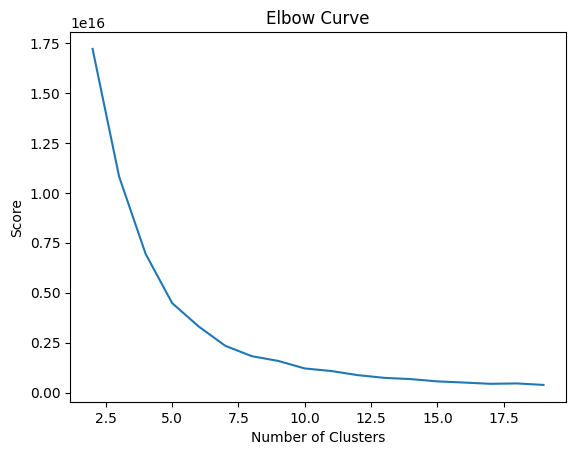

In [50]:
# 이너시아 그래프
# Calculate cost and plot
cost = np.zeros(20)

for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(transformed_data)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
df_cost.insert(0, 'cluster', new_col)

import matplotlib.pyplot as plt
plt.plot(df_cost['cluster'], df_cost['cost'])
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [51]:
# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1).setFeaturesCol('features')
model = kmeans.fit(transformed_data)

# Make predictions
predictions = model.transform(transformed_data).select('track_id', 'track_name', 'prediction')
predictions.show()

+--------------------+--------------------+----------+
|            track_id|          track_name|prediction|
+--------------------+--------------------+----------+
|0kTnTtBHAsNS1dYYt...|          Brick Dust|         0|
|04Qoeu8OuooChg0SA...|             Windows|         3|
|0KSDW6PlZu4QiQZpl...|          Dark Water|         0|
|0aCUTE2bqOPuxAzSH...|Fix It Up And Go ...|         5|
|0iryDHISEcNkmniJV...|  Sophisticated Lady|         1|
|0RoL3gauardnsgPJ5...|    God's Meditation|         1|
|0AzAaHxrFAP9x0LXW...|           Sor Mi Mu|         1|
|0Dv85AfwTdskjEt2t...|   Ukraine Freestyle|         5|
|0RW1UL8w8rjQkaIal...|Photo ID (with Do...|         1|
|0UK3CK1iqpfgSJnTn...|               My Ex|         1|
|0dgUhMtrxfWOvBT7S...|         Listen More|         1|
|0AkzLKdGhZPO3roVb...|        Overthinking|         0|
|0eaPRzmCLPs9rMyAV...|          E.STA.A.TE|         1|
|050pTOv6GcGadxWcS...|         Wieczór Już|         1|
|0kCc1ZlpuEXKiL2zw...|August 4, 1964: H...|         5|
|0aSG0K0gR

In [52]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 3.19599901e+05  9.46371135e+00  5.26207824e+00  6.21203923e-01
  3.87382537e+00  1.18130884e+02  3.78666782e-01  5.21365667e-01
  5.51644067e-01  3.07145007e-01  2.02215844e-01 -1.10746478e+01
  7.38367902e-02  3.96763165e-01]
[ 2.13238796e+05  1.25712728e+01  5.26207931e+00  6.36833160e-01
  3.89981345e+00  1.18767327e+02  3.74711451e-01  5.65372900e-01
  5.70990229e-01  1.68842198e-01  1.95195660e-01 -9.62172554e+00
  9.20732156e-02  4.75747315e-01]
[ 3.79416609e+06  4.33928571e+00  5.43303571e+00  5.95982143e-01
  3.93750000e+00  1.15884975e+02  2.46660424e-01  4.96687946e-01
  6.41005111e-01  3.74222570e-01  2.42226786e-01 -1.10930469e+01
  1.50016518e-01  2.94967411e-01]
[ 5.15618260e+05  5.95777618e+00  5.21733571e+00  6.21209854e-01
  3.83457348e+00  1.13789863e+02  4.99810077e-01  4.41534998e-01
  4.42882900e-01  5.17250214e-01  2.05396215e-01 -1.45387150e+01
  6.45072749e-02  2.86495846e-01]
[ 1.09005339e+06  3.98596212e+00  4.91736194e+00  6.82028870e-01
 

24/01/11 14:09:31 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/01/11 14:09:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce